In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
# We change the default level of the logger so that
# we can see what's happening with caching.
import logging, sys, os
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c

# For plotting the cubes, we use the plotting submodule:
from py21cmfast import plotting

# For interacting with the cache
from py21cmfast import cache_tools

import numpy as np
import collections.abc
#py21cmmc needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
#py21cmmc needs the below
np.int = np.int32
#Now import py21cmmc
from py21cmmc import analyse
from py21cmmc import mcmc
import py21cmmc as p21mc


Error accessing global_Ts: 'TsBox' object has no attribute '_computed_arrays'
Available attributes: ['Ts_box', '_OutputStruct__expose', '_OutputStruct__memory_map', '_StructWrapper__cstruct', '_TYPEMAP', '__abstractmethods__', '__call__', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_array_state', '_array_structure', '_ary2buf', '_c_based_pointers', '_c_compute_function', '_c_shape', '_call_hooks', '_check_parameters', '_compute', '_cstruct', '_ensure_arguments_exist', '_ffi', '_fields_', '_filter_params', '_find_file_without_seed', '_fname_skeleton', '_get_box_structures', '_get_fname', '_get_name', '_get_path', '_global_params', '_impl

/opt/miniconda3/envs/21cmfast/lib/python3.11/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)
/opt/miniconda3/envs/21cmfast/lib/python3.11/site-packages/powerbox/tools.py:732: UserWarning: One or more radial bins had no cells within it.
  return angular_average(


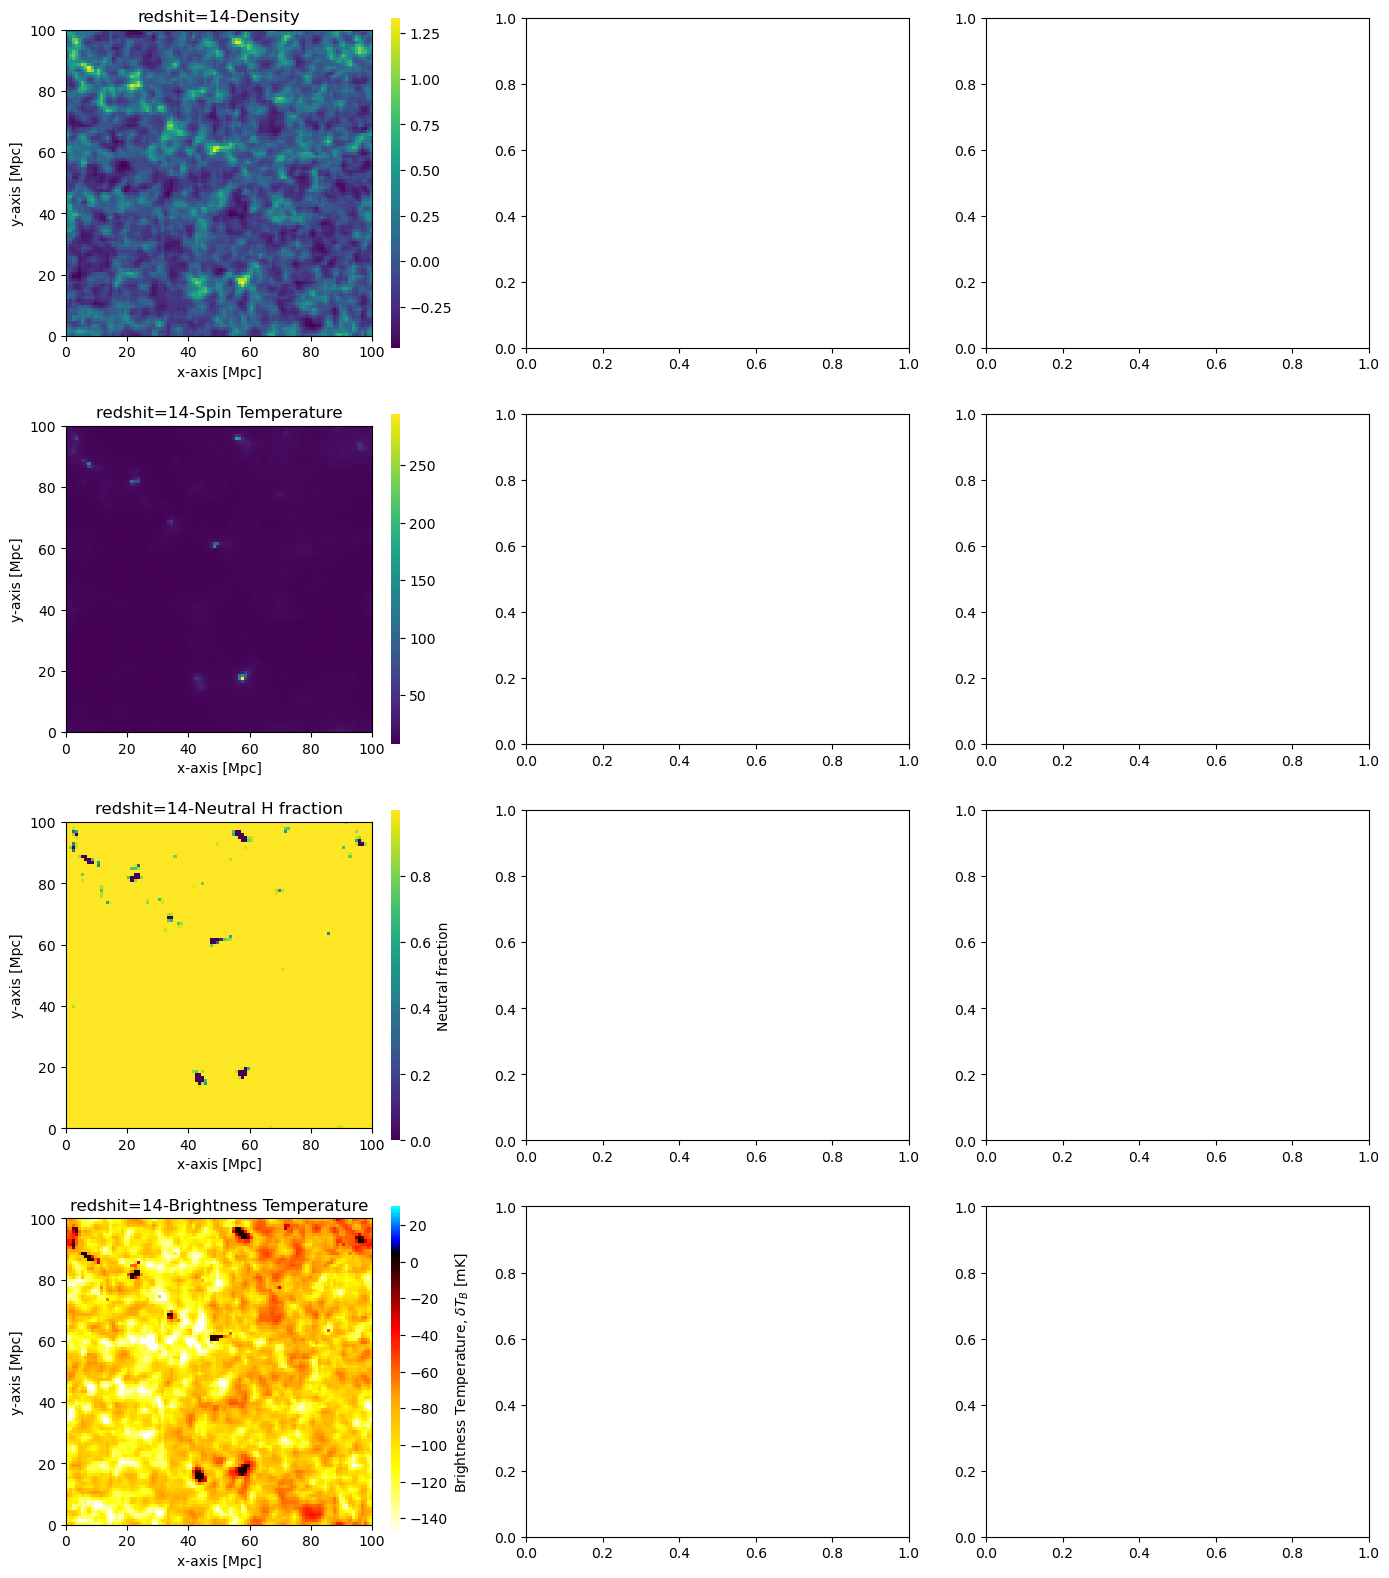

In [9]:
user_params = {"HII_DIM": 100, "BOX_LEN": 100, "USE_INTERPOLATION_TABLES": False}

initial_conditions = p21c.initial_conditions(
    user_params = user_params,
)

fig, ax = plt.subplots(5, 3, figsize=(14,20))
for i, redshift in enumerate([14, 10, 6]):
    #######
    # Create perturbed field at the redshift
    perturbed_field = p21c.perturb_field( redshift = redshift, init_boxes = initial_conditions)
    plotting.coeval_sliceplot(perturbed_field, "density", ax=ax[0][i], fig = fig)
    ax[0][i].title.set_text('redshit={0}-Density'.format(redshift))

    #######
    # Compute the spin temperatures
    spin_temp = p21c.spin_temperature(
        perturbed_field = perturbed_field,
        zprime_step_factor=1.05,
    )
    plotting.coeval_sliceplot(spin_temp, "Ts_box", ax=ax[1][i], fig = fig);
    ax[1][i].title.set_text('redshit={0}-Spin Temperature'.format(redshift))
    # Try accessing global_Ts
    global_Ts = spin_temp.Ts_box_struct.global_Ts
    print('Global TS at redshit={0} is {1:.4f}'.format(redshift, global_Ts))

    #######
    # Compute ionization
    ionized_field = p21c.ionize_box(
        spin_temp = spin_temp,
        zprime_step_factor=1.05
    )
    plotting.coeval_sliceplot(ionized_field, "xH_box", ax=ax[2][i], fig = fig)
    ax[2][i].title.set_text('redshit={0}-Neutral H fraction'.format(redshift))

    #######
    # Compute brightness temperature
    brightness_temp = p21c.brightness_temperature(
        ionized_box = ionized_field,
        perturbed_field = perturbed_field,
        spin_temp = spin_temp
    )
    plotting.coeval_sliceplot(brightness_temp, ax=ax[3][i], fig = fig)
    ax[3][i].title.set_text('redshit={0}-Brightness Temperature'.format(redshift))

    #######
    # Compute Power Spectrum of brightness_temp
    ps = p21mc.Likelihood1DPowerCoeval.compute_power(brightness_temp.brightness_temp, L=100, n_psbins = 100) 
    plt.plot(ps[0], ps[1], ax=ax[4][i], fig = fig)
    ax[4][i].title.set_text('redshit={0}-Power Spectrum'.format(redshift))

    
plt.tight_layout()